### Load data from excel file

Read data from excel

In [ ]:
import pandas as pd
file_path = "path/to/SuppTable1.xlsx"

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# ------------------------------
# Step 1: Separate metadata & features
# ------------------------------
metadata = df.iloc[:, :20]  # First 20 columns (metadata)
features = df.iloc[:, 20:]  # Remaining columns (features)

# ------------------------------
# Step 2: Standardize the features
# ------------------------------
scaler = StandardScaler()
# Drop any feature columns with NaN values
features_clean = features.dropna(axis=1)
scaled_features = scaler.fit_transform(features_clean)

# ------------------------------
# Step 3: Create a combined DataFrame of metadata and scaled features
# ------------------------------
combined_df = pd.concat([
    metadata.reset_index(drop=True),
    pd.DataFrame(scaled_features, columns=features_clean.columns).reset_index(drop=True)
], axis=1)

### code for when you want to train a model with 3 classes (ExPEC, IPEC, Non-Pathogen)

In [ ]:
# # ------------------------------
# # Step 4: Prepare training data for three classes
# # ------------------------------
# # We want to include rows with "IPEC", "ExPEC", "Non Pathogen" and "Healthy-Community"
# # Then, merge "Non Pathogen" and "Healthy-Community" into one class: "Non-Pathogen"

# # Use the original Source.curated column for filtering
# labels = metadata["Source.curated"]

# # Define the valid labels for training
# valid_labels = ["IPEC", "ExPEC", "Non Pathogen", "Healthy-Community"]

# # Filter the combined_df to include only rows with the valid labels
# df_filtered = combined_df[labels.isin(valid_labels)].copy()

# # Merge "Non Pathogen" and "Healthy-Community" into one label "Non-Pathogen"
# df_filtered["MergedLabel"] = df_filtered["Source.curated"].apply(
#     lambda x: "Non-Pathogen" if x in ["Non Pathogen", "Healthy-Community"] else x
# )
# # Move "MergedLabel" to the first column
# column_order = ["MergedLabel"] + [col for col in df_filtered.columns if col != "MergedLabel"]
# df_filtered = df_filtered[column_order]

# # Now you can filter like this:
# X = df_filtered.iloc[:, 17:]  # Features (starting from column index 17)
# y = df_filtered["MergedLabel"]
# # Encode the target labels (this will yield three classes)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
# print("Encoded classes:", label_encoder.classes_)  # e.g. might print: ['ExPEC', 'IPEC', 'Non-Pathogen']

# # ------------------------------
# # Step 5: Split the data into training and test sets
# # ------------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
# )
# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=42)
# X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
# print("Train/Test shapes:", X_train.shape, X_test.shape)


Encoded classes: ['ExPEC' 'IPEC' 'Non-Pathogen']
Train/Test shapes: (102613, 262) (12814, 262)


### Code to split the data in a train and test set (0.8-0.2) for two classes IPEC & ExPEC

In [ ]:
# ------------------------------
# Step 4: Prepare training data (only IPEC and ExPEC rows)
# ------------------------------
# Use the original Source.curated from metadata for filtering
labels = metadata["Source.curated"]
df_filtered = combined_df[labels.isin(["IPEC", "ExPEC"])]

X = df_filtered.iloc[:, 20:]  # Scaled feature columns
y = df_filtered["Source.curated"]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Check the encoding order:
print("Encoded classes:", label_encoder.classes_)  
# Typically, this will print: ['ExPEC' 'IPEC']

# ------------------------------
# Step 5: Split the data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Encoded classes: ['ExPEC' 'IPEC']
Train/Test shapes: (50651, 262) (12663, 262)


### Setting up the different types of models and defining a grid of hyperparameters for the model selection that will occur in the next step

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
     "Random Forest": RandomForestClassifier(random_state=42),
     "Logistic Regression": LogisticRegression(max_iter=1000),
     "K-Nearest Neighbors": KNeighborsClassifier(),
     "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network": MLPClassifier(max_iter=500)
}

param_grids = {
    "Random Forest": {"n_estimators": [50, 100], "max_depth": [None]},
    "Logistic Regression": {"C": [0.1, 1, 10], "solver": ["liblinear"]},
    "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7]},
    "Gradient Boosting": {"n_estimators": [50], "learning_rate": [0.01, 0.1]},
    "Extra Trees": {"n_estimators": [100, 200], "max_depth": [None]},
    "Decision Tree": {"max_depth": [5, 10]},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,)], "activation": ["relu", "tanh"]}
}

### Finding the best model through 5-fold cross validation and assessing the performance

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

best_models = {}
best_accuracy = 0
best_model_name = None
best_model_final = None  # Overall best model

for name, model in models.items():
    print(f"🔹 Tuning {name}...")
    
    # Use grid search if there is a parameter grid for the model
    if name in param_grids:
        grid_search = GridSearchCV(
            model, 
            param_grids[name], 
            cv=cv, 
            scoring="accuracy", 
            n_jobs=-1, 
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        current_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"✅ Best Parameters for {name}: {best_params}")
    else:
        model.fit(X_train, y_train)
        current_model = model
        best_params = "N/A"
    
    # Evaluate the current model on the test set
    y_pred = current_model.predict(X_test)
    y_prob = current_model.predict_proba(X_test)[:, 1]  # For ROC-AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,)
    f1 = f1_score(y_test, y_pred,)
    roc_auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Parameters": best_params,
        "Test Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })
    
    print(f"Confusion Matrix for {name}:\n{conf_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    best_models[name] = current_model
    
    # Update overall best model if current model's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model_final = current_model

print(f"\n🏆 Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")


🔹 Tuning Random Forest...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
✅ Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Confusion Matrix for Random Forest:
[[4060   45]
 [  74 8484]]
Accuracy: 0.9906
🔹 Tuning Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best Parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Confusion Matrix for Logistic Regression:
[[4061   44]
 [ 132 8426]]
Accuracy: 0.9861
🔹 Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best Parameters for K-Nearest Neighbors: {'n_neighbors': 3}
Confusion Matrix for K-Nearest Neighbors:
[[4031   74]
 [ 134 8424]]
Accuracy: 0.9836
🔹 Tuning Naive Bayes...
Confusion Matrix for Naive Bayes:
[[4105    0]
 [ 451 8107]]
Accuracy: 0.9644
🔹 Tuning Gradient Boosting...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
✅ Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'n_esti

### Save performance parameters in excel file

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to an Excel file
results_df.to_excel("./model_results.xlsx", index=False)
print("✅ Results saved to model_results.xlsx")

✅ Results saved to model_results.xlsx


### Save model to pickle file

In [ ]:
with open("./best_model.pkl", "wb") as f:
    pickle.dump(best_model_final, f)

print(f"✅ Best model ({best_model_name}) saved to best_model.pkl")

✅ Best model (Extra Trees) saved to best_model.pkl


In [ ]:
best_model_final= pickle.load(open("./best_model.pkl", "rb"))

### Make predictions and store them in a separate column "Source.predicted"

In [ ]:
# ------------------------------
# Step 7: Predict on ND rows
# ------------------------------
# Select rows from combined_df where Source.curated is "ND"
df_nd = combined_df[combined_df["Source.curated"] == "ND"]


# For ND rows, extract the same features (already scaled in combined_df)
nd_features = df_nd.loc[:, features_clean.columns]
nd_features_scaled = nd_features.values  # Already scaled

# Predict using the best model on ND rows
nd_predictions = best_model_final.predict(nd_features_scaled)
print("ND predictions (numeric):", nd_predictions)

# ------------------------------
# Step 8: Create the Source.predicted column in the original df
# ------------------------------
# Start by copying Source.curated
df['Source.predicted'] = df['Source.curated']

# For ND rows, update Source.predicted with the model's predictions
# IMPORTANT: Because label_encoder.classes_ is ['ExPEC', 'IPEC'],
# a prediction of 0 corresponds to ExPEC and 1 corresponds to IPEC.
# We want to mark them as "ND_ExPEC" and "ND_IPEC" respectively.
nd_mapping = {0: 'ND_ExPEC', 1: 'ND_IPEC'}
# Locate ND rows in the original df and update Source.predicted
df.loc[df['Source.curated'] == 'ND', 'Source.predicted'] = pd.Series(nd_predictions, index=df[df['Source.curated'] == 'ND'].index)
# Now map the numeric predictions to the desired strings
df.loc[df['Source.curated'] == 'ND', 'Source.predicted'] = df.loc[df['Source.curated'] == 'ND', 'Source.predicted'].map(nd_mapping)

# For any rows not updated (if any NaN appears), fill with the original value
df['Source.predicted'] = df['Source.predicted'].fillna(df['Source.curated'])

# ------------------------------
# Step 9: Reorder columns so Source.predicted is next to Source.curated
# ------------------------------
cols = df.columns.tolist()
# Remove Source.predicted and insert it after Source.curated
cols.remove("Source.predicted")
index_curated = cols.index("Source.curated")
cols.insert(index_curated + 1, "Source.predicted")
df = df[cols]

# ------------------------------
# Final Verification
# ------------------------------
print(df[['Source.curated', 'Source.predicted']].head(10))

In [24]:
# Check the proportions of 'Source.predicted'
predicted_proportions = df['Source.predicted'].value_counts(normalize=True)

# Print the proportions
print(predicted_proportions)
print(df.columns.tolist())

Source.predicted
ND_ExPEC             0.452747
IPEC                 0.325135
ExPEC                0.155938
ND_IPEC              0.047428
Clinical             0.008632
Healthy-Community    0.004339
Pathogen             0.003184
Non Pathogen         0.001390
Mixed                0.001208
Name: proportion, dtype: float64
['Barcode', 'Source.Niche', 'Source.Type', 'Source.Details', 'Source.curated', 'Source.predicted', 'ExPEC.type', 'IPEC.type', 'Collection.Year', 'Continent', 'Country', 'ST.Complex', 'fimH.fimTyper', 'ExPEC_STs', 'ST', 'PG', 'Pathovar', 'CT6SSi2', 'CT6SSi1', 'CT6SSi4b', 'CM_bin', 'PM_bin', 'PT6SSi2', 'PT6SSi1', 'PT6SSi4b', 'CMT6SSi2', 'CMT6SSi1', 'CMT6SSi4b', 'PMT6SSi2', 'PMT6SSi1', 'PMT6SSi4b', 'CST6SSi2', 'CST6SSi1', 'CST6SSi4b', 'PST6SSi2', 'PST6SSi1', 'PST6SSi4b', 'AAA92657', 'AAC38364', 'C_RS05810', 'KP1_RS17280', 'KP1_RS17355', 'aslA', 'cesAB', 'cesD', 'cesD2', 'cesF', 'cesL', 'cesT', 'cfaA', 'cfaB', 'cfaC', 'cfaD.cfaE', 'chuA', 'chuS', 'chuT', 'chuU', 'chuV', 'chuW

### Train the model with the same parameters, check the performance as validation, and extract the feature importances

In [25]:
# Train Extra Trees Classifier
extra_trees = ExtraTreesClassifier(max_depth=None, n_estimators=200, random_state=42)
extra_trees.fit(X_train, y_train)
y_pred = extra_trees.predict(X_test)
y_prob = extra_trees.predict_proba(X_test)[:, 1]  # For ROC-AUC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
#roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for Extra Trees:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Get feature importances
feature_importances = extra_trees.feature_importances_

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame({"Feature": X.dropna(axis=1).columns, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

Confusion Matrix for Extra Trees:
[[4060   45]
 [  70 8488]]
Accuracy: 0.9909
Precision: [0.98305085 0.99472636]
Recall: [0.98903776 0.99182052]
F1-Score: [0.98603522 0.99327131]


### Plot the feature importances

In [ ]:
importance_df.to_excel("./feature_importances.xlsx", index=False)

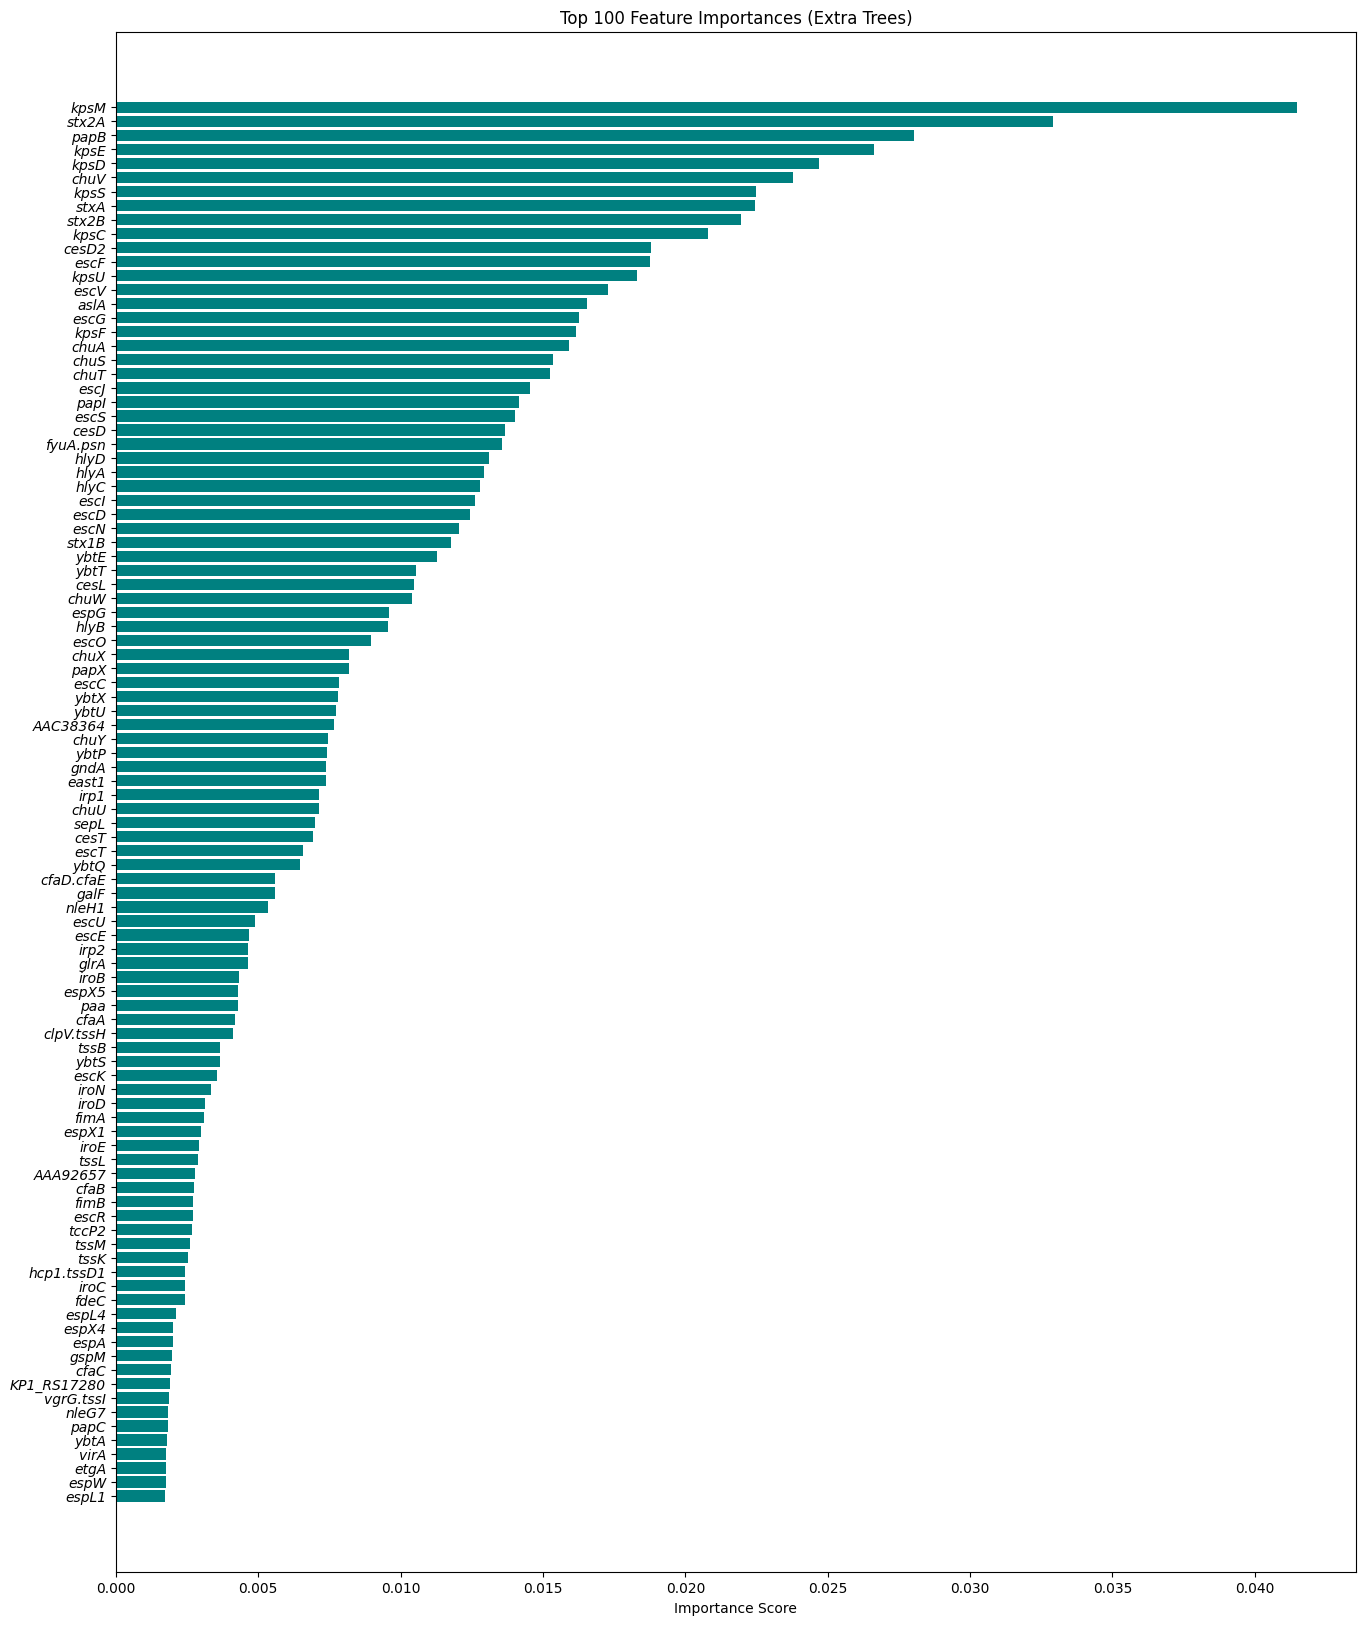

In [61]:
# --- Plot Feature Importances ---
plt.figure(figsize=(16,20))
plt.barh(importance_df["Feature"][:100], importance_df["Importance"][:100], color="teal")  # Top 20 features
plt.xlabel("Importance Score")
plt.yticks(fontstyle="italic")

plt.title("Top 100 Feature Importances (Extra Trees)")
plt.gca().invert_yaxis()  # Reve3rse order for better readability
plt.show()